In [169]:
import pandas as pd
import seaborn as sns
%matplotlib inline

In [126]:
data = pd.read_pickle('data/data_prepared')
if 'index' in data.columns:
    data.drop('index', axis=1, inplace=True)

In [127]:
data.shape

(76074, 55)

In [128]:
data.head(3)

,mp_sup_key,date,order_defect_rate_median,late_shipment_rate_median,cancellation_rate_median,valid_tracking_rate_all_cat_median,late_responses_median,fba_median,return_dissatisfaction_rate_median,customer_service_dissatisfaction_rate_beta_median,...,sharpe_ratio,sales_7_days_change_from_1_period,sales_7_days_change_from_2_period,sales_30_days_change_from_1_period,sales_30_days_change_from_2_period,sales_tresh,small,medium,large,very_large
0,000b068c-69b3-426e-a506-9914eaf8710b,2018-01-07,0.235,0.245,0.755,99.150,33.5,0.0,0.0,0.0,...,7.630785,NaN,NaN,NaN,NaN,"(0, 1000]",1,0,0,0
1,000b068c-69b3-426e-a506-9914eaf8710b,2018-01-21,0.220,0.000,0.480,98.690,37.0,0.0,0.0,50.0,...,10.018296,0.033468,NaN,-0.202819,NaN,"(0, 1000]",1,0,0,0
2,000b068c-69b3-426e-a506-9914eaf8710b,2018-02-04,0.240,0.000,0.360,98.675,26.0,0.0,0.0,100.0,...,9.319781,0.276564,0.319289,-0.012933,-0.213129,"(0, 1000]",1,0,0,0


In [129]:
# number of observations per mp
obs = data.mp_sup_key.value_counts()
obs_cut_level = 10
desired_suppliers = obs[obs > obs_cut_level]

In [130]:
 data = data.loc[data.mp_sup_key.isin(desired_suppliers.index)]

In [131]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68763 entries, 0 to 76070
Data columns (total 55 columns):
mp_sup_key                                           68763 non-null object
date                                                 68763 non-null datetime64[ns]
order_defect_rate_median                             65845 non-null float64
late_shipment_rate_median                            65139 non-null float64
cancellation_rate_median                             65027 non-null float64
valid_tracking_rate_all_cat_median                   51318 non-null float64
late_responses_median                                60363 non-null float64
fba_median                                           65852 non-null float64
return_dissatisfaction_rate_median                   40466 non-null float64
customer_service_dissatisfaction_rate_beta_median    54540 non-null float64
delivered_on_time_median                             57273 non-null float64
sales_7_days_median                              

In [132]:
by = 'mp_sup_key'

In [133]:
#remove first two observations per supplier
rows_to_drop = data.groupby(by).head(2).index
data.drop(rows_to_drop, inplace=True)

In [134]:
data.reset_index(inplace=True, drop=True)

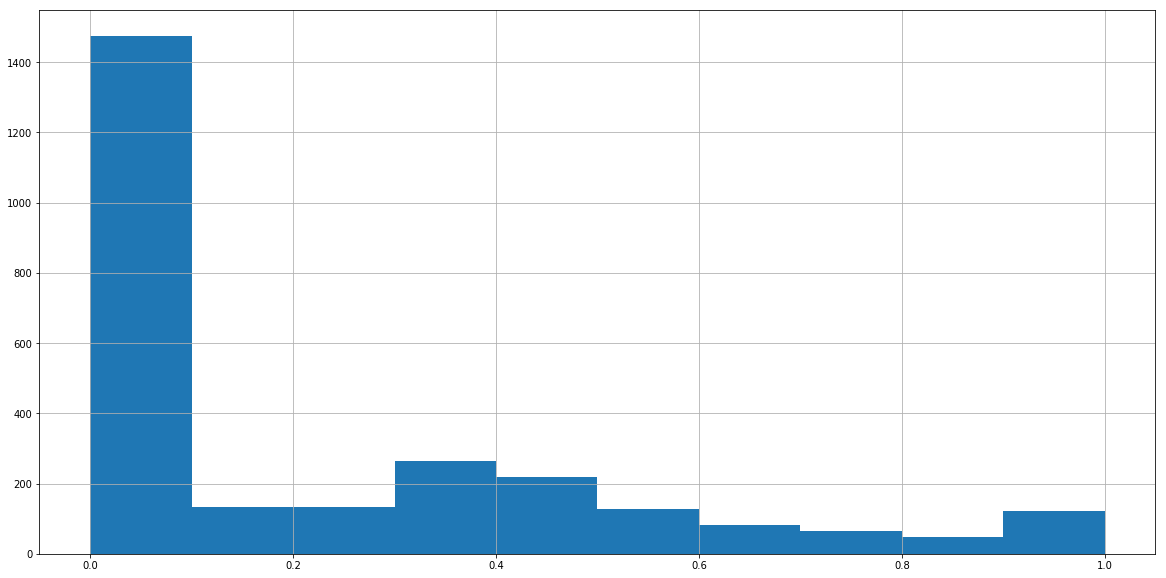

In [135]:
data.groupby(by)['fba_median'].mean().hist(figsize = (20,10))

In [136]:
fba_cut_level = [-0.01, 0.1, 0.5, 0.9, 1]
fba_cut_labels = ['no_fba', 'some_fba', 'most_fba', 'full_fba']

In [137]:
data['fba_tresh'] = pd.cut(data.fba_median, fba_cut_level)
dummies = pd.get_dummies(data.fba_tresh)
dummies.columns = fba_cut_labels


In [138]:
data = pd.concat([data, dummies], axis=1)

In [139]:
data['suspended'] = 0
data.loc[data.future_status == 2, 'suspended'] = 1

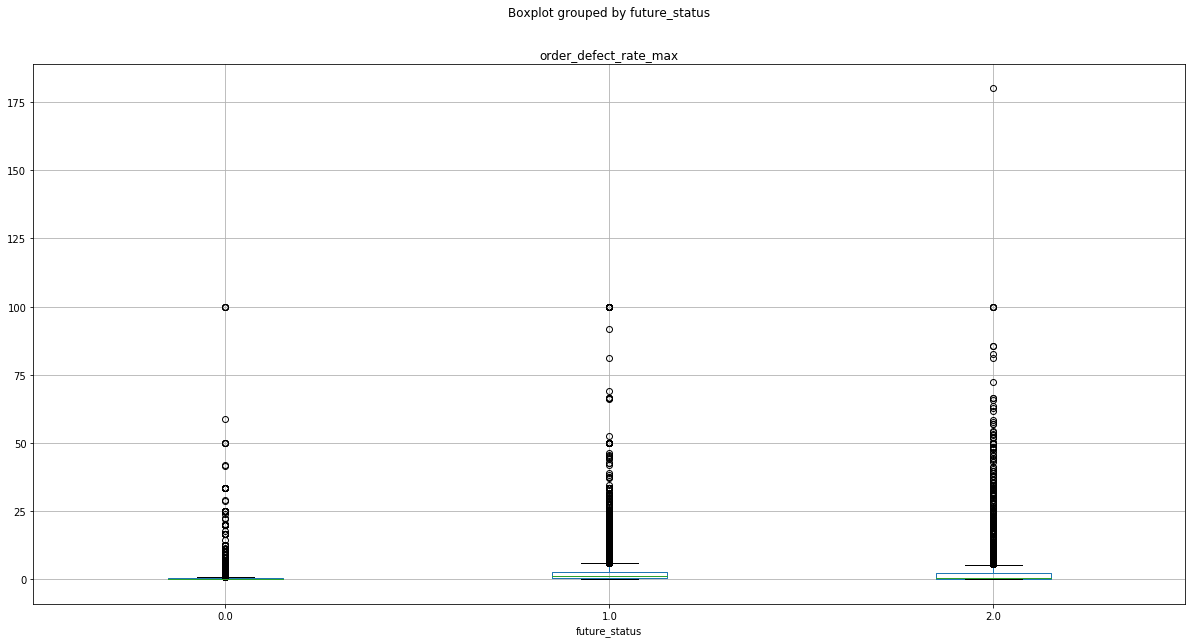

In [16]:
data.boxplot(column='order_defect_rate_max', by = 'future_status', figsize = (20,10));

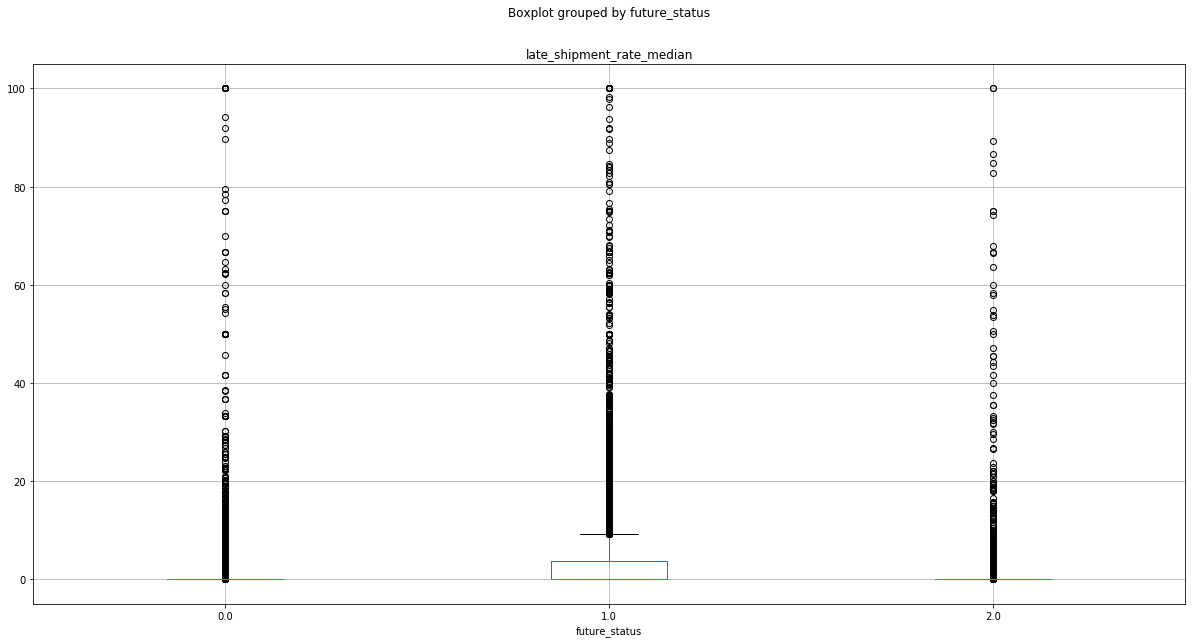

In [17]:
data.boxplot(column='late_shipment_rate_median', by = 'future_status', figsize = (20,10));

In [140]:
data['year'] = data.date.dt.year
data['quarter'] = data.date.dt.quarter

In [141]:
data.head(2)

,mp_sup_key,date,order_defect_rate_median,late_shipment_rate_median,cancellation_rate_median,valid_tracking_rate_all_cat_median,late_responses_median,fba_median,return_dissatisfaction_rate_median,customer_service_dissatisfaction_rate_beta_median,...,large,very_large,fba_tresh,no_fba,some_fba,most_fba,full_fba,suspended,year,quarter
0,000b068c-69b3-426e-a506-9914eaf8710b,2018-02-04,0.24,0.0,0.36,98.675,26.0,0.0,0.0,100.0,...,0,0,"(-0.01, 0.1]",1,0,0,0,0,2018,1
1,000b068c-69b3-426e-a506-9914eaf8710b,2018-02-18,0.24,0.0,1.31,98.645,41.5,0.0,0.0,100.0,...,0,0,"(-0.01, 0.1]",1,0,0,0,0,2018,1


In [142]:
def cumsum_wo_zero(y):
    return pd.DataFrame(y * (y.groupby((y != y.shift(1)).cumsum()).cumcount() + 1))

In [143]:
by_sup_date = [by, 'year', 'quarter']
data.sort_values(by_sup_date, inplace=True)

data = data.assign(
    conse_suspension = data.groupby(by_sup_date, sort=False)['suspended'].apply(lambda x: cumsum_wo_zero(x))
)

In [145]:
data.loc[data.conse_suspension > 0, ['suspended', 'conse_suspension']][:10]

,suspended,conse_suspension
109,1,1
112,1,1
113,1,2
120,1,1
121,1,2
172,1,1
174,1,1
175,1,2
176,1,3
177,1,4


In [150]:
data = data.loc[data.conse_suspension <= 1]

In [154]:
data.suspended.value_counts()

0    60177
1     1258
Name: suspended, dtype: int64

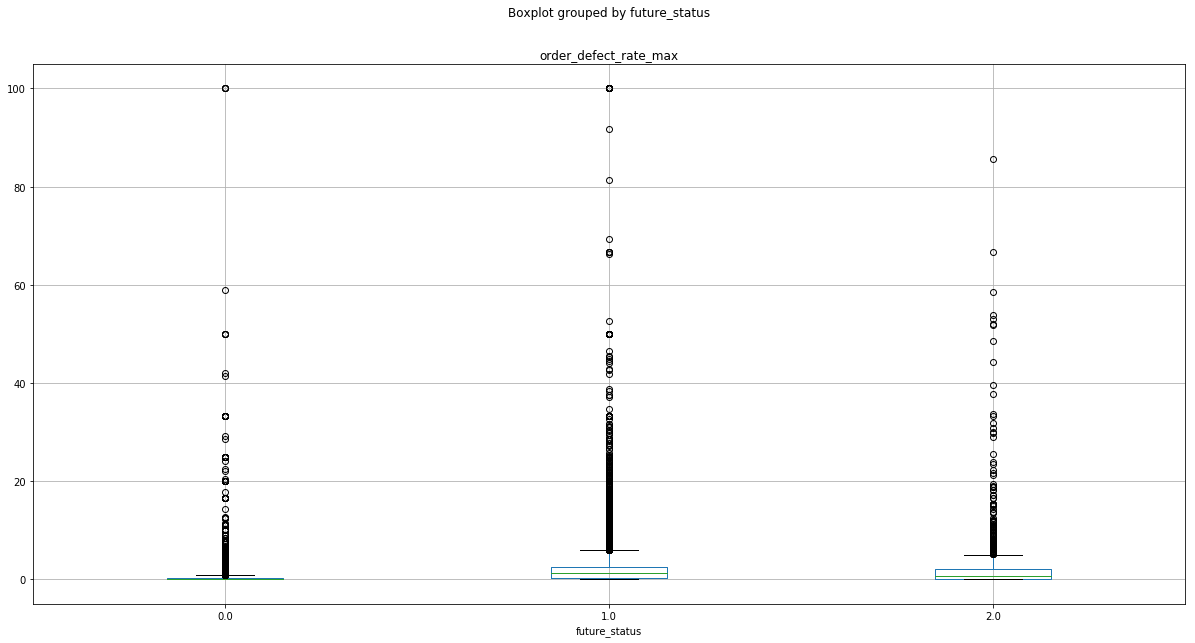

In [153]:
data.boxplot(column='order_defect_rate_max', by = 'future_status', figsize = (20,10));

In [158]:
data['suspended'] = pd.Categorical(data.suspended)

In [167]:
data.columns

Index(['mp_sup_key', 'date', 'order_defect_rate_median',
       'late_shipment_rate_median', 'cancellation_rate_median',
       'valid_tracking_rate_all_cat_median', 'late_responses_median',
       'fba_median', 'return_dissatisfaction_rate_median',
       'customer_service_dissatisfaction_rate_beta_median',
       'delivered_on_time_median', 'sales_7_days_median',
       'sales_30_days_median', 'r_score_median', 'f_score90_median',
       'f_score180_median', 'm_score90_median', 'm_score180_median',
       'order_defect_rate_max', 'late_shipment_rate_max',
       'cancellation_rate_max', 'late_responses_max',
       'return_dissatisfaction_rate_max',
       'customer_service_dissatisfaction_rate_beta_max', 'sales_7_days_max',
       'sales_30_days_max', 'products_removal_max', 'policy_warning_max',
       'invoice_requested_max', 'intellectual_property_max',
       'infringement_max', 'pricing_error_max',
       'negative_customer_experiences_max', 'reserve_max', 'other_max',
       '

In [163]:
import matplotlib.pyplot as plt

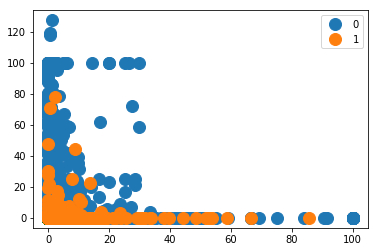

<Figure size 1800x1080 with 0 Axes>

In [168]:
groups = data.groupby('suspended')

fig, ax = plt.subplots()
plt.figure(figsize=(25,15))
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group.order_defect_rate_max, group.cancellation_rate_median, marker='o', linestyle='', ms=12, label=name)
ax.legend()

plt.show()

/Users/gevorgkhangeldyan/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)
/Users/gevorgkhangeldyan/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/Users/gevorgkhangeldyan/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/Users/gevorgkhangeldyan/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result eit

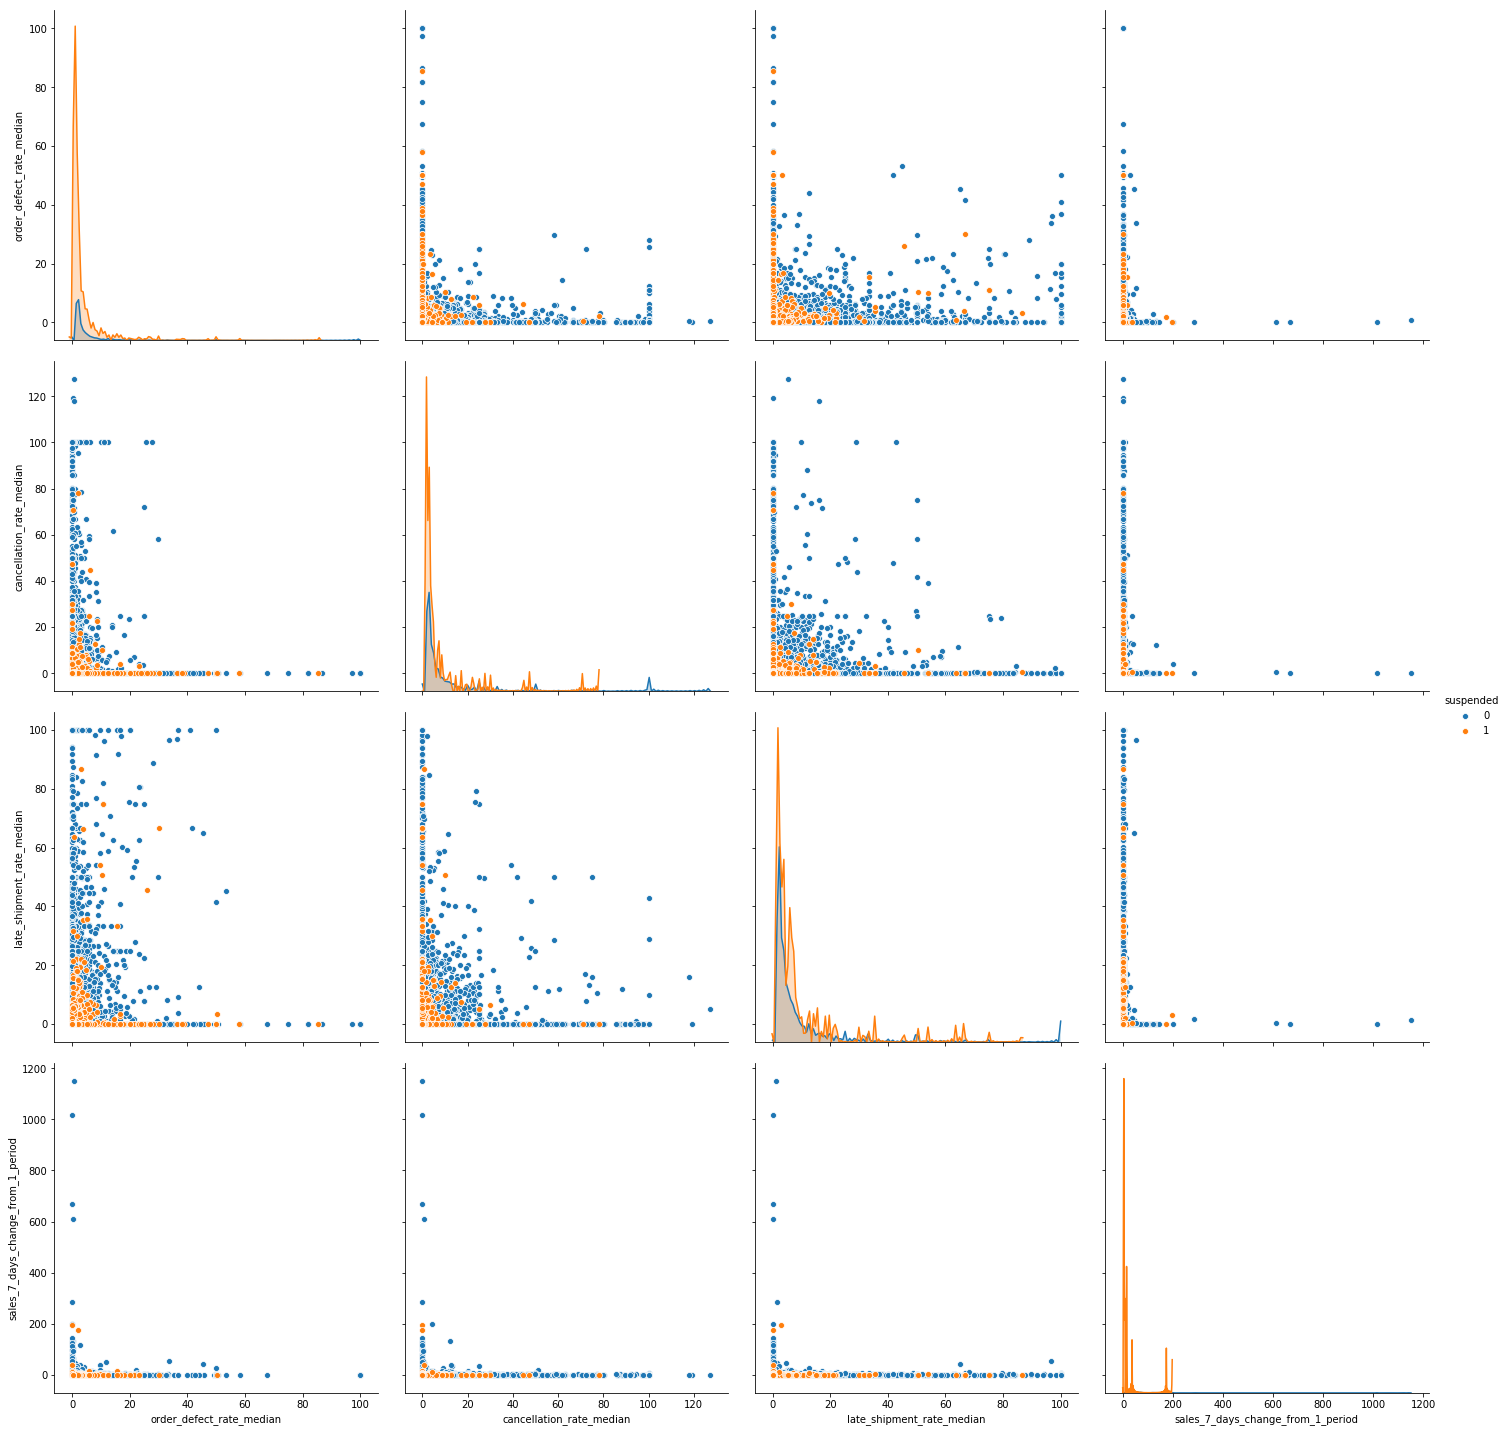

In [170]:
sns.pairplot(vars=["order_defect_rate_median","cancellation_rate_median","late_shipment_rate_median",
                  'sales_7_days_change_from_1_period'], data=data, hue="suspended", size=5)

In [173]:
data.groupby('suspended').describe().stack().to_clipboard()

In [174]:
data.to_pickle('data/data_II_preparation')